In [32]:
import pickle as pkl
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from imblearn.over_sampling import SMOTE
%config InlineBackend.figure_formats = ['retina']  # or svg
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 20)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

load model

In [27]:
model = pkl.load(open("../Models/xgb_balanced.pkl", "rb"))   

load data

In [33]:
df = pd.read_pickle('../Data/survey_data_cleaned2.pkl')

Balance data

In [40]:
X = df[['database_count', 'Age1stCode', 'YearsCodePro', 'Age','YearsCode', 'EdLevel', 
         'Gender', 'UndergradMajor', 'Region', 
        'Hobbyist', 'back-end', 'full-stack', 'front-end', 'desktop', 'mobile', 'DevOps', 'Database admin', 
        'Designer','System admin', 'Student', 'Other Occupation', 'Retired Dev','Sometimes Code at Work', 
       'JavaScript', 'Python', 'SQL', 'Java', 'HTML/CSS']]
y = df['OpSys']

X = pd.get_dummies(X)

X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X,y)

In [36]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [41]:
X.columns

Index(['database_count', 'Age1stCode', 'YearsCodePro', 'Age', 'YearsCode',
       'EdLevel_AA/AS', 'EdLevel_BA/BS', 'EdLevel_MA/PhD', 'EdLevel_None',
       'EdLevel_Prof', 'EdLevel_Some Univ', 'EdLevel_Student', 'Gender_Man',
       'Gender_Woman', 'Gender_gender non-conforming', 'UndergradMajor_Arts',
       'UndergradMajor_Comp Sci/Eng', 'UndergradMajor_Eng',
       'UndergradMajor_Health/Nat Sci', 'UndergradMajor_Human/Social Sci',
       'UndergradMajor_Info Tech/Sys', 'UndergradMajor_Math/Stats',
       'UndergradMajor_None', 'UndergradMajor_Web Dev', 'Region_Africa',
       'Region_Asia', 'Region_Australia', 'Region_Baltics', 'Region_CIS',
       'Region_Europe', 'Region_M East', 'Region_N America',
       'Region_S America', 'Region_other', 'Hobbyist_No', 'Hobbyist_Yes',
       'back-end_No', 'back-end_Yes', 'full-stack_No', 'full-stack_Yes',
       'front-end_No', 'front-end_Yes', 'desktop_No', 'desktop_Yes',
       'mobile_No', 'mobile_Yes', 'DevOps_No', 'DevOps_Yes',
       

In [42]:
X_smoted_cat = X_smoted[[ 
                           'EdLevel_AA/AS', 'EdLevel_BA/BS', 'EdLevel_MA/PhD', 'EdLevel_None',
                           'EdLevel_Prof', 'EdLevel_Some Univ', 'EdLevel_Student', 'Gender_Man',
                           'Gender_Woman', 'Gender_gender non-conforming', 'UndergradMajor_Arts',
                           'UndergradMajor_Comp Sci/Eng', 'UndergradMajor_Eng',
                           'UndergradMajor_Health/Nat Sci', 'UndergradMajor_Human/Social Sci',
                           'UndergradMajor_Info Tech/Sys', 'UndergradMajor_Math/Stats',
                           'UndergradMajor_None', 'UndergradMajor_Web Dev', 'Region_Africa',
                           'Region_Asia', 'Region_Australia', 'Region_Baltics', 'Region_CIS',
                           'Region_Europe', 'Region_M East', 'Region_N America',
                           'Region_S America', 'Region_other', 'Hobbyist_No', 'Hobbyist_Yes',
                           'back-end_No', 'back-end_Yes', 'full-stack_No', 'full-stack_Yes',
                           'front-end_No', 'front-end_Yes', 'desktop_No', 'desktop_Yes',
                           'mobile_No', 'mobile_Yes', 'DevOps_No', 'DevOps_Yes',
                           'Database admin_No', 'Database admin_Yes', 'Designer_No',
                           'Designer_Yes', 'System admin_No', 'System admin_Yes', 'Student_No',
                           'Student_Yes', 'Other Occupation_No', 'Other Occupation_Yes',
                           'Retired Dev_No', 'Retired Dev_Yes', 'Sometimes Code at Work_No',
                           'Sometimes Code at Work_Yes', 'JavaScript_No', 'JavaScript_Yes',
                           'Python_No', 'Python_Yes', 'SQL_No', 'SQL_Yes', 'Java_No', 'Java_Yes',
                           'HTML/CSS_No', 'HTML/CSS_Yes']]
X_smoted_num = X_smoted[['database_count', 'Age1stCode', 'YearsCodePro', 'Age','YearsCode']]

X_balanced = undummify(X_smoted_cat)

Concat into df2

In [45]:
df2 = df = pd.concat((X_balanced,X_smoted_num, y_smoted), axis=1)
#print(df2)

### EDA of Balanced Data

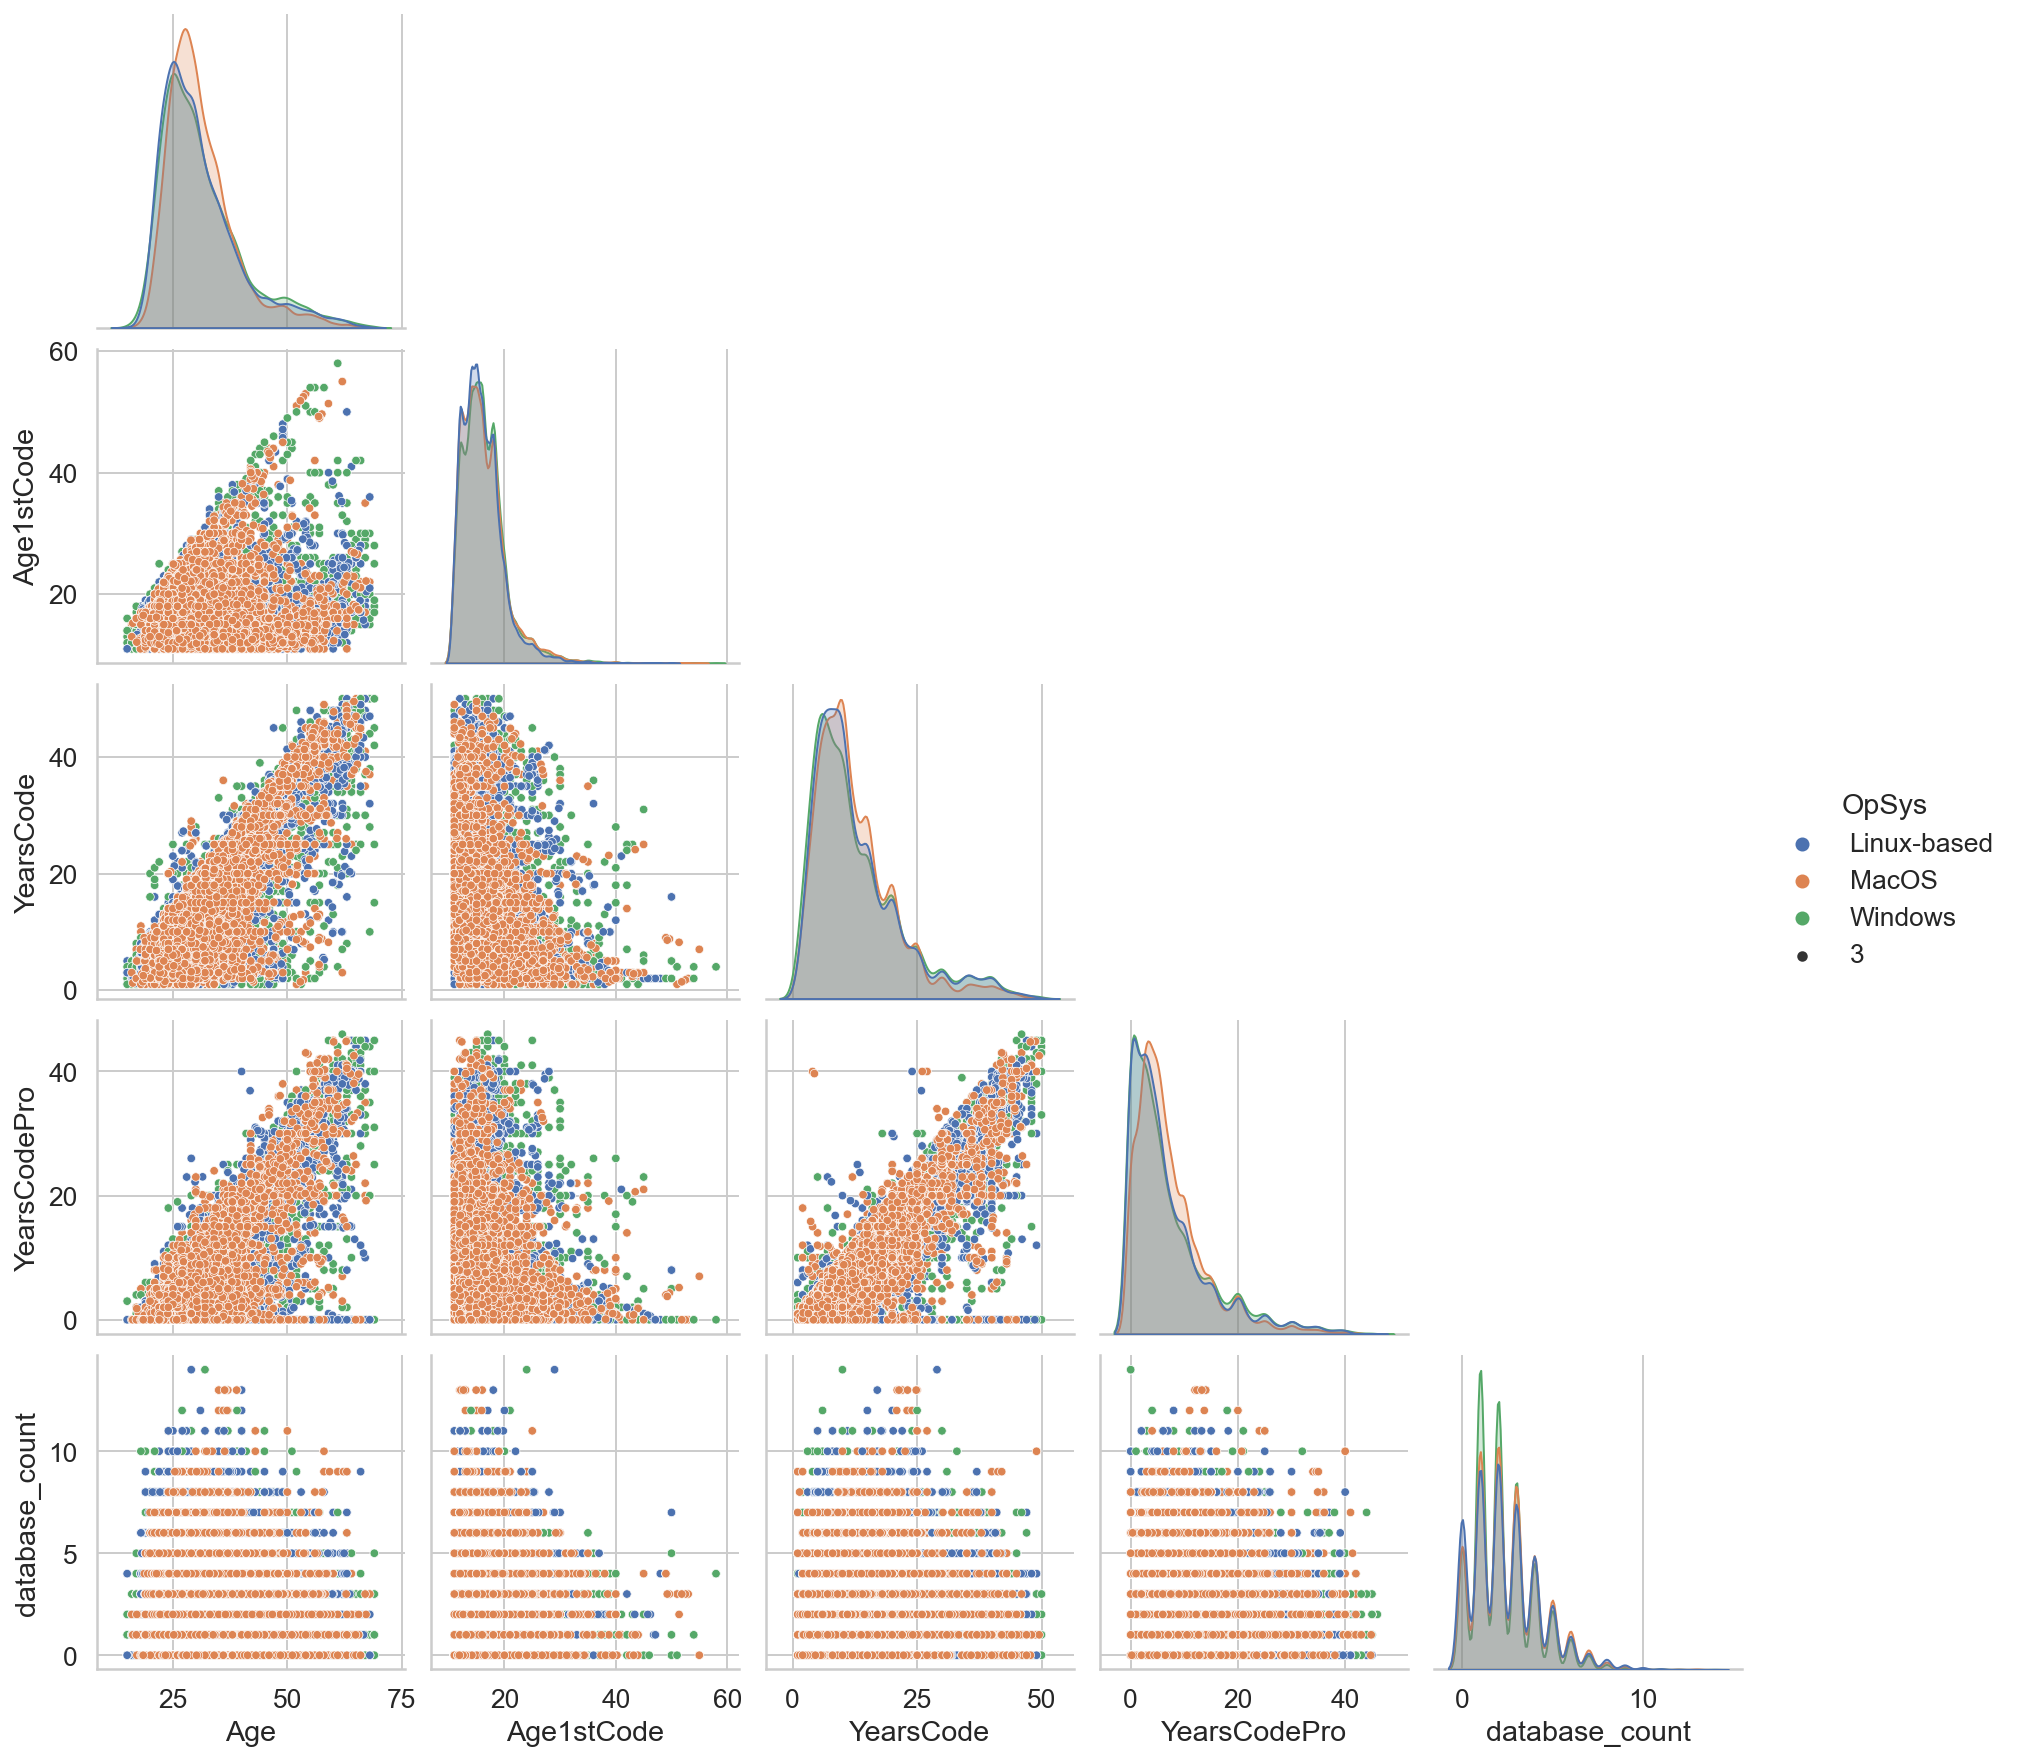

In [47]:
plt.rcParams['figure.figsize']=(1,2)
#We want to pick one feature to start that separates the two cases.
sns.pairplot(df2[['OpSys', 'Age', 'Age1stCode', 'YearsCode', 'YearsCodePro', 'database_count']], 
             corner=True, plot_kws={'size': 3}, hue='OpSys')

<ipython-input-51-4623687ddd5c>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


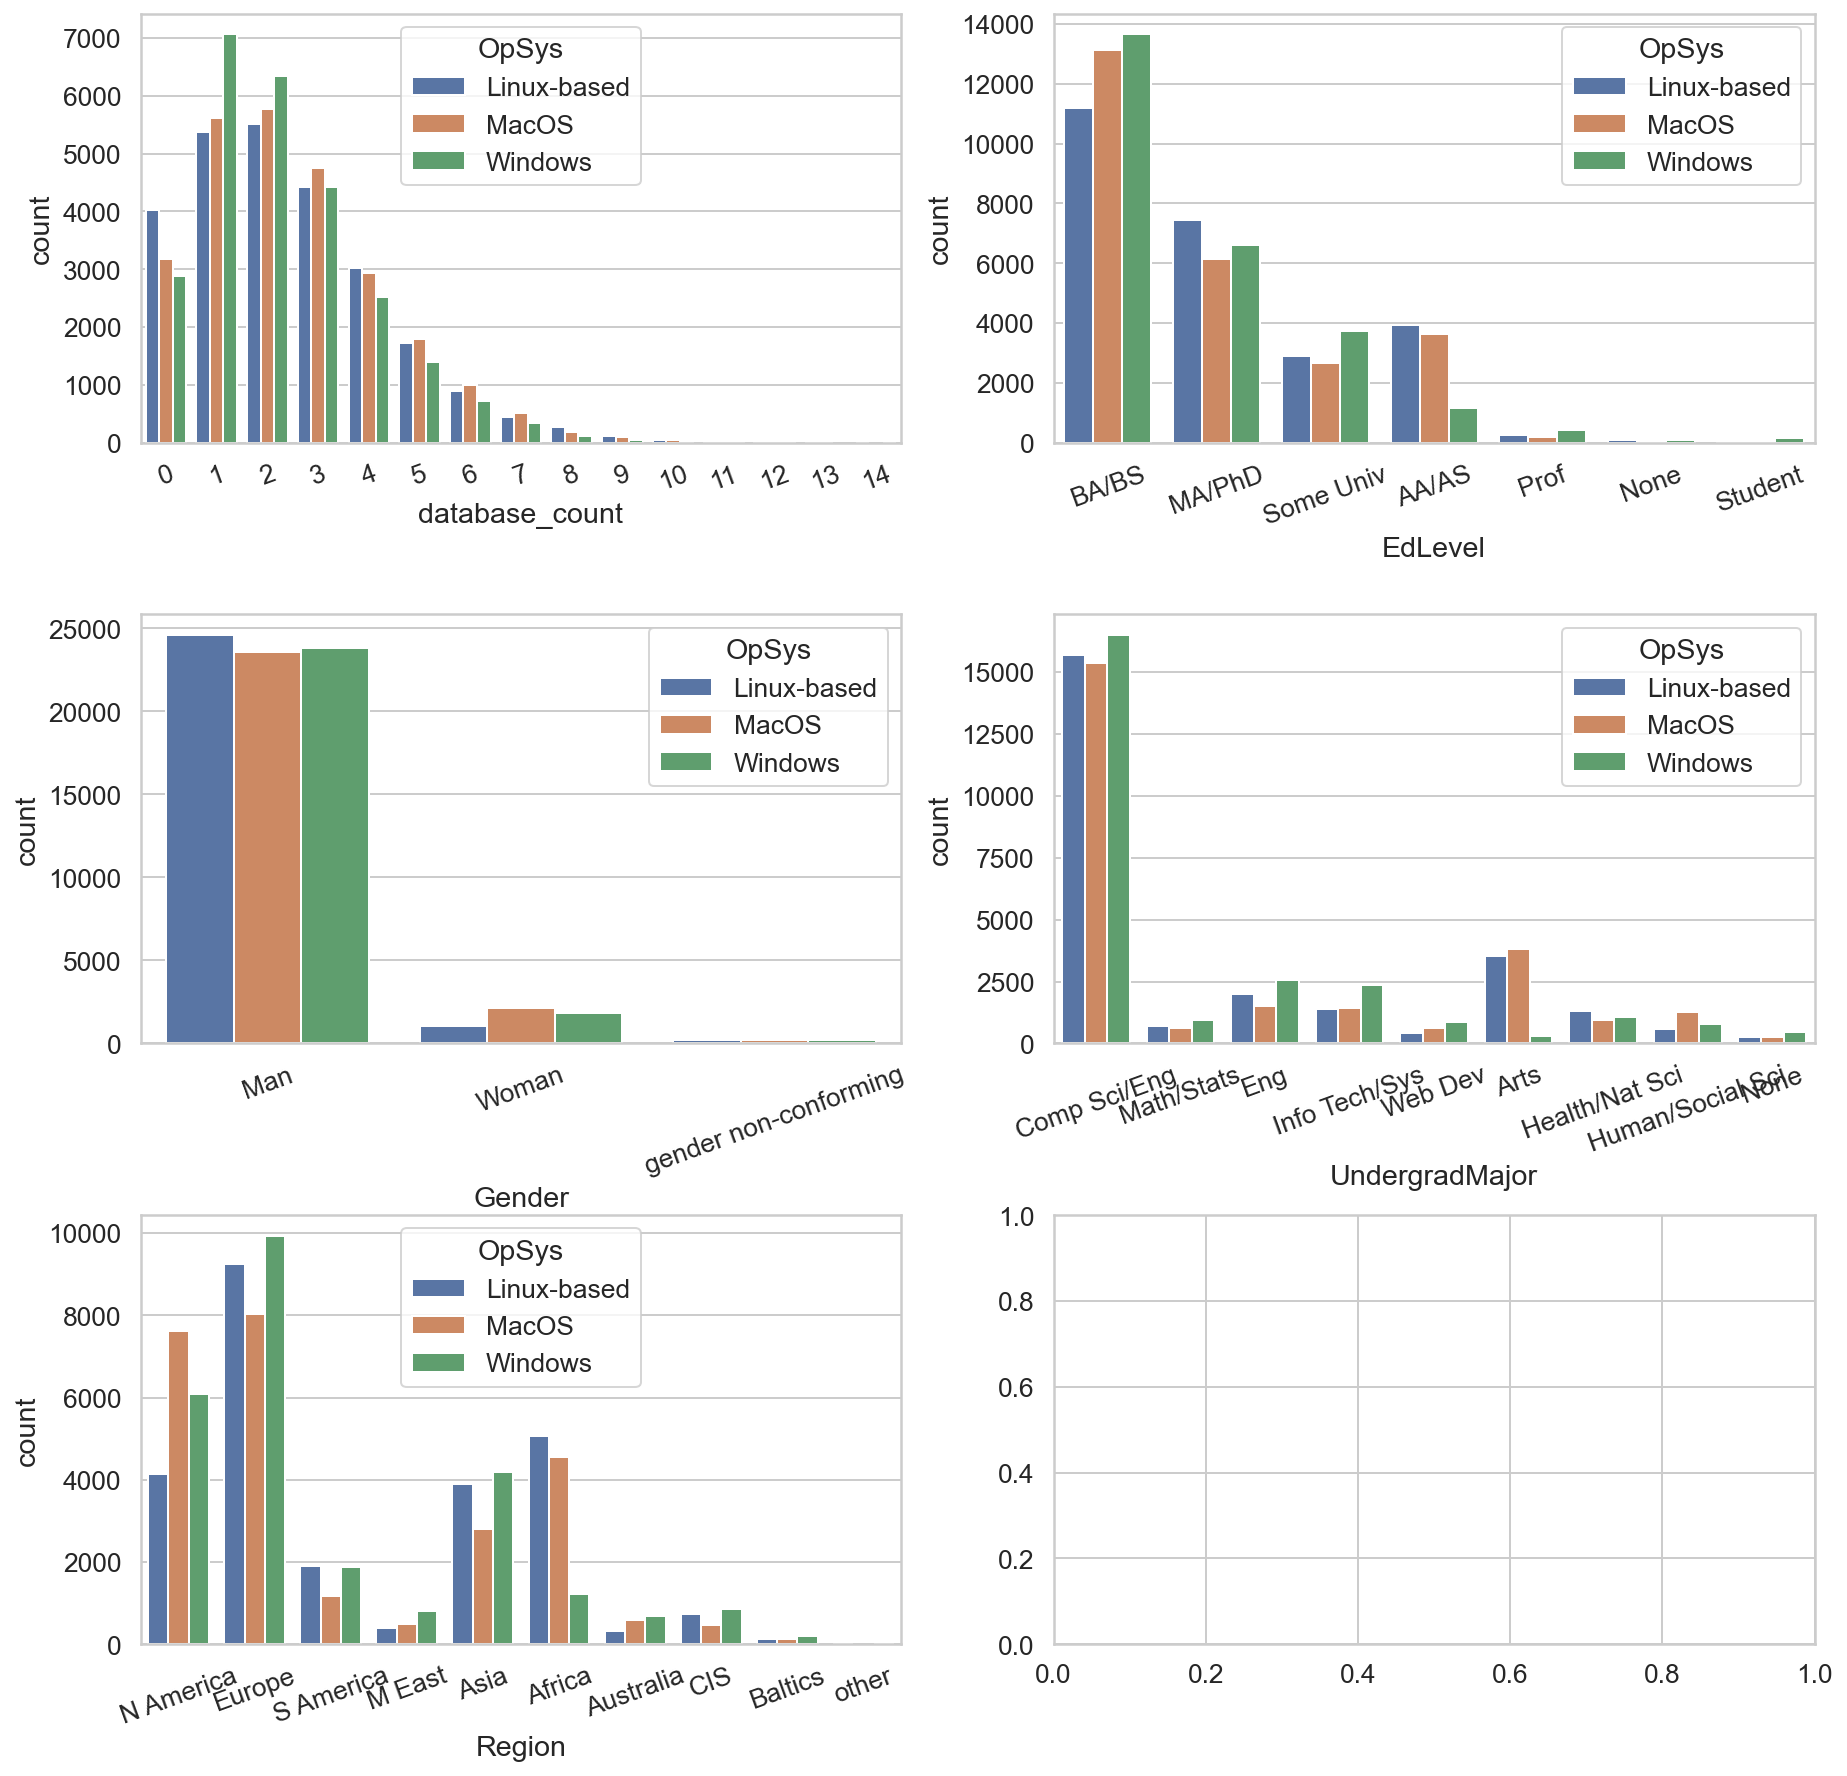

In [51]:
categorical_columns = ['database_count', 'EdLevel',  'Gender', 'UndergradMajor', 'Region']
fig, ax =plt.subplots(3,2, gridspec_kw={'hspace': 0.4, 'wspace': 0.2}, figsize=(15,15))
idx = 0
for x in range(0,3):
    for y in range(0,2):
        if idx >= 5:
            break
        sns.countplot(x = categorical_columns[idx], hue='OpSys', data=df2, ax=ax[x,y])
        ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(),rotation=20)
        idx= idx+1
fig.show()

<ipython-input-50-c92b63623eb6>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


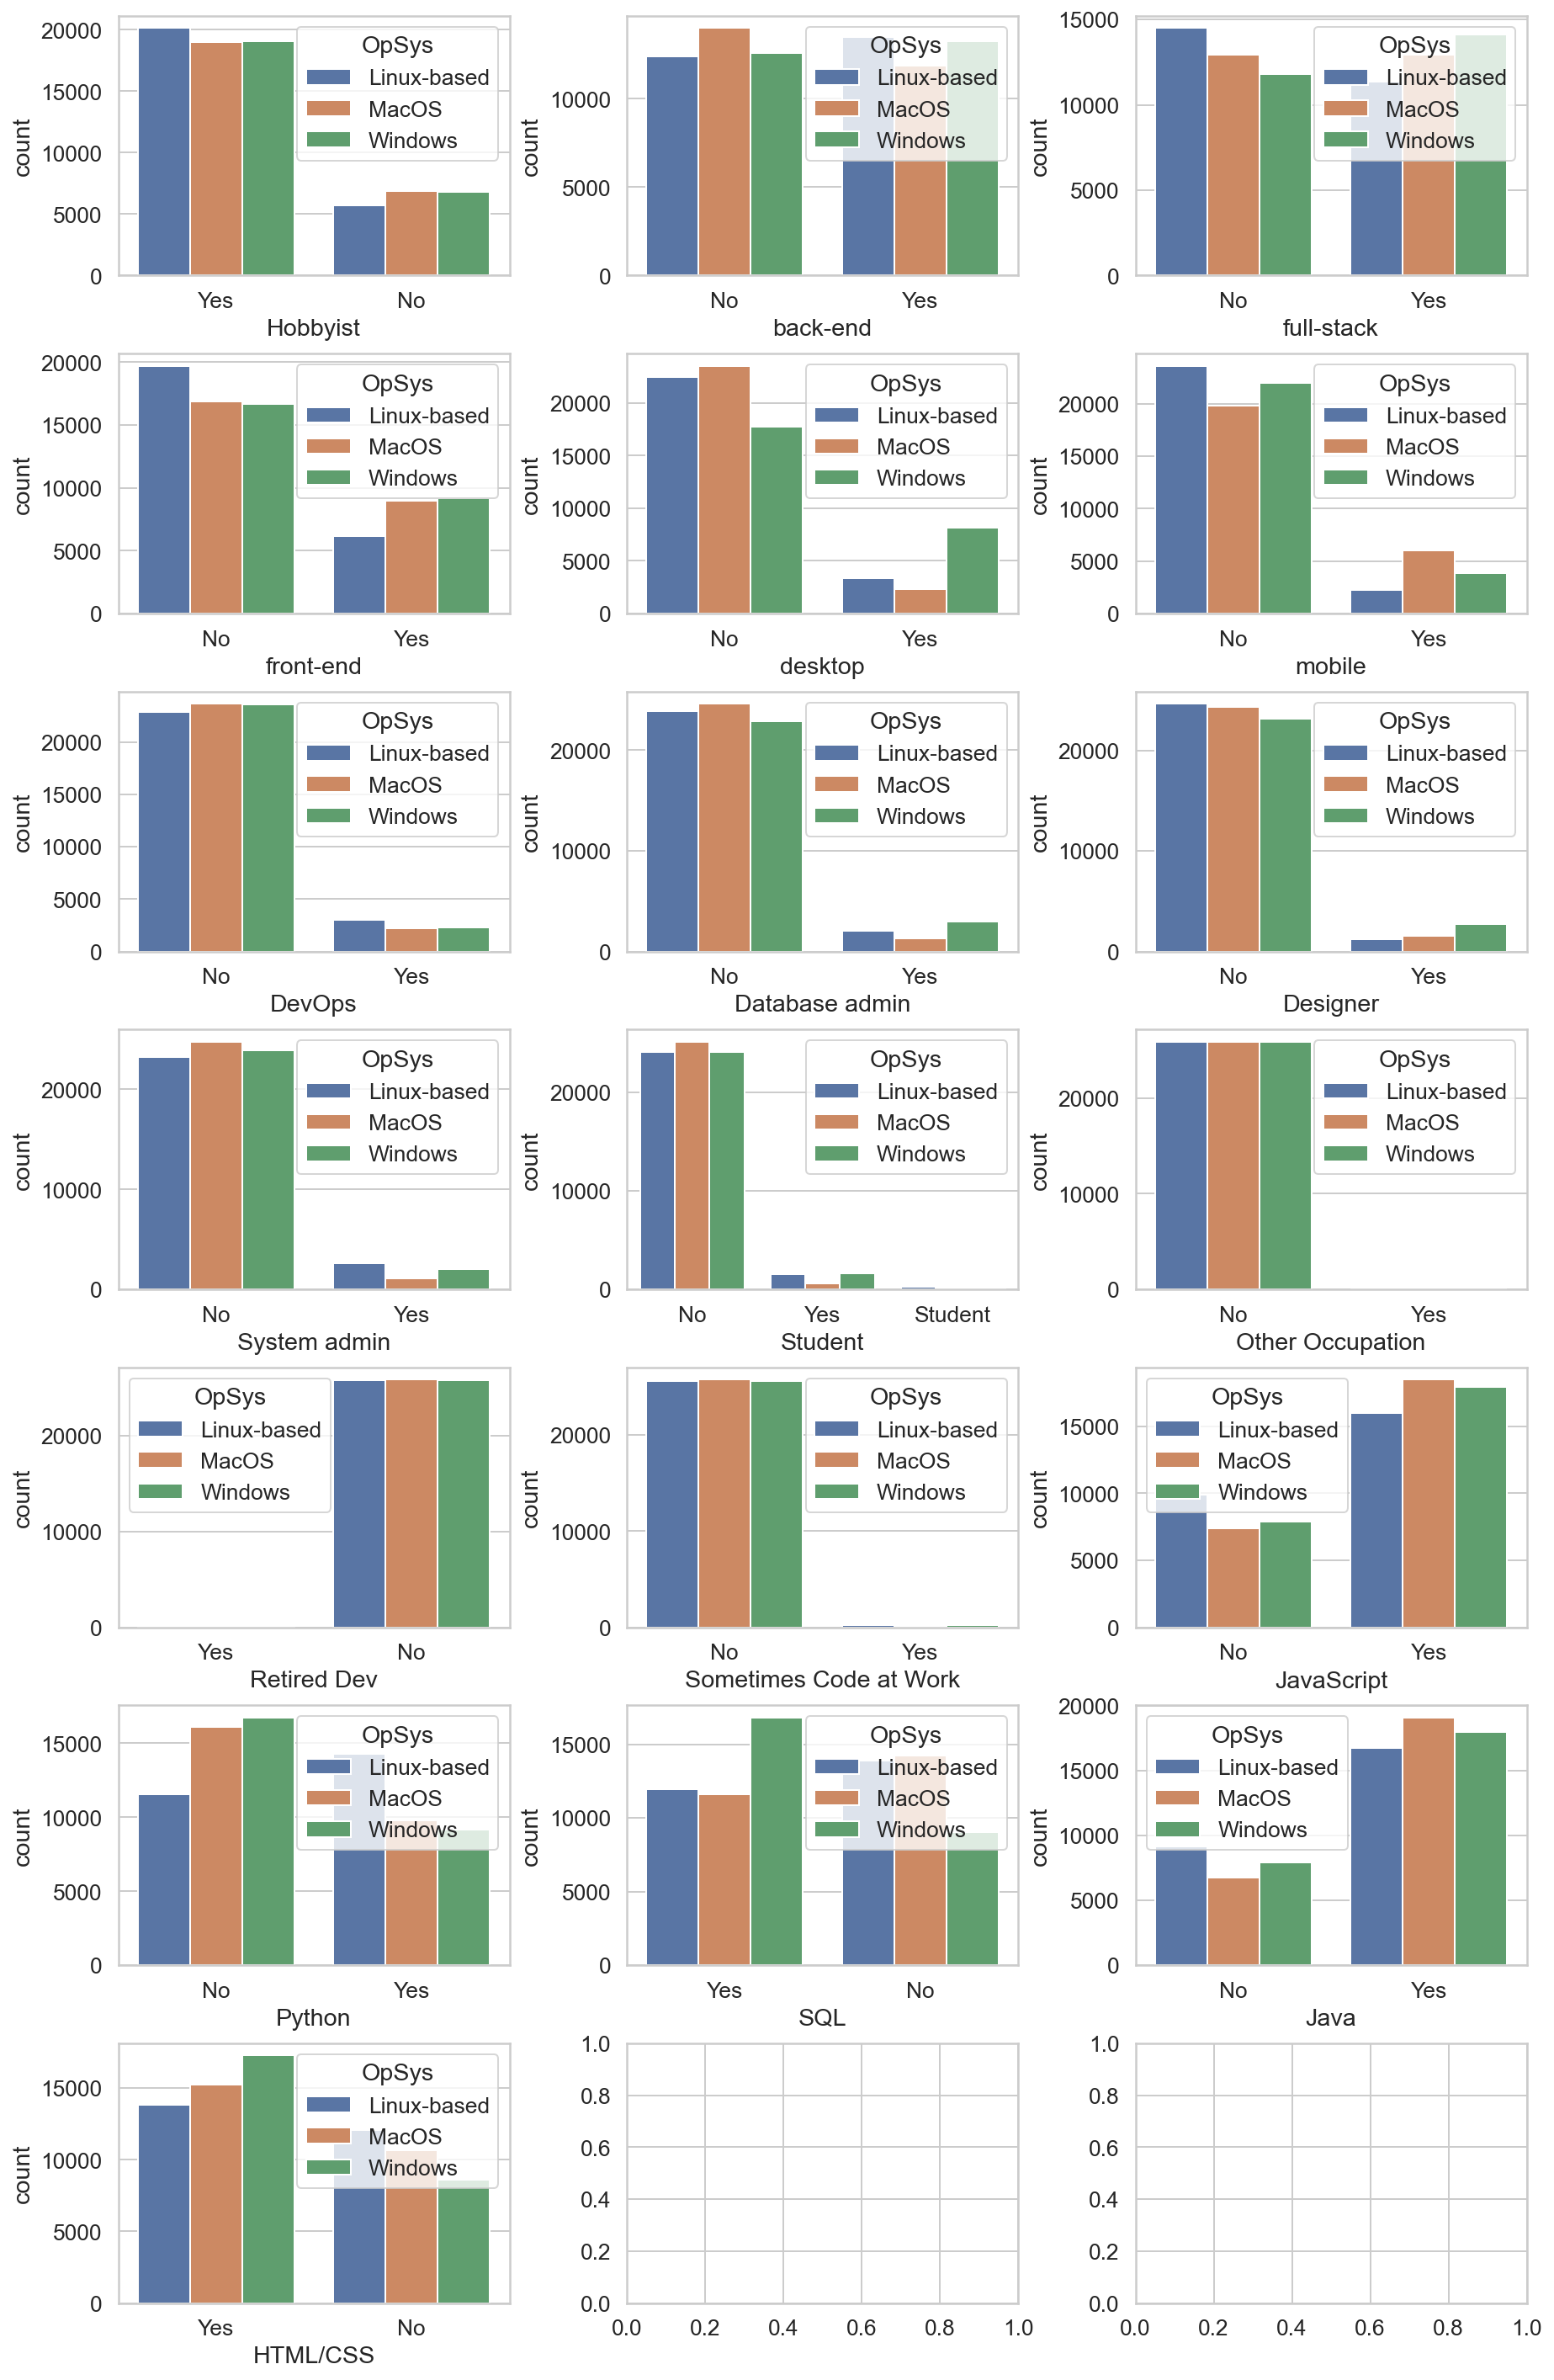

In [50]:
binary_columns = ['Hobbyist', 'back-end', 'full-stack', 'front-end', 'desktop', 'mobile', 'DevOps', 'Database admin', 'Designer',
                 'System admin', 'Student', 'Other Occupation', 'Retired Dev','Sometimes Code at Work',
                 'JavaScript', 'Python', 'SQL', 'Java', 'HTML/CSS']
fig, ax =plt.subplots(7,3, gridspec_kw={'hspace': 0.3, 'wspace': 0.3}, figsize=(15,25))
idx = 0
for x in range(0,7):
    for y in range(0,3):
        if idx >= 19:
            break
        sns.countplot(x = binary_columns[idx], hue='OpSys', data=df2, ax=ax[x,y])
        idx= idx+1
fig.show()

plot feature importance

In [15]:
model.feature_importances_

array([0.01123018, 0.01142222, 0.0120033 , 0.01139684, 0.01087749,
       0.00988198, 0.01128047, 0.07548388, 0.01796028, 0.0867303 ,
       0.02890652, 0.01159548, 0.03025095, 0.03642082, 0.03331509,
       0.05042462, 0.08229931, 0.0531645 , 0.01061529, 0.05448157,
       0.00958351, 0.05086445, 0.01695671, 0.02658027, 0.        ,
       0.00980229, 0.01097381, 0.04480443, 0.03115939, 0.02371149,
       0.0284744 , 0.03513624, 0.00839813, 0.01108325, 0.01194026,
       0.02018264, 0.01060776], dtype=float32)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

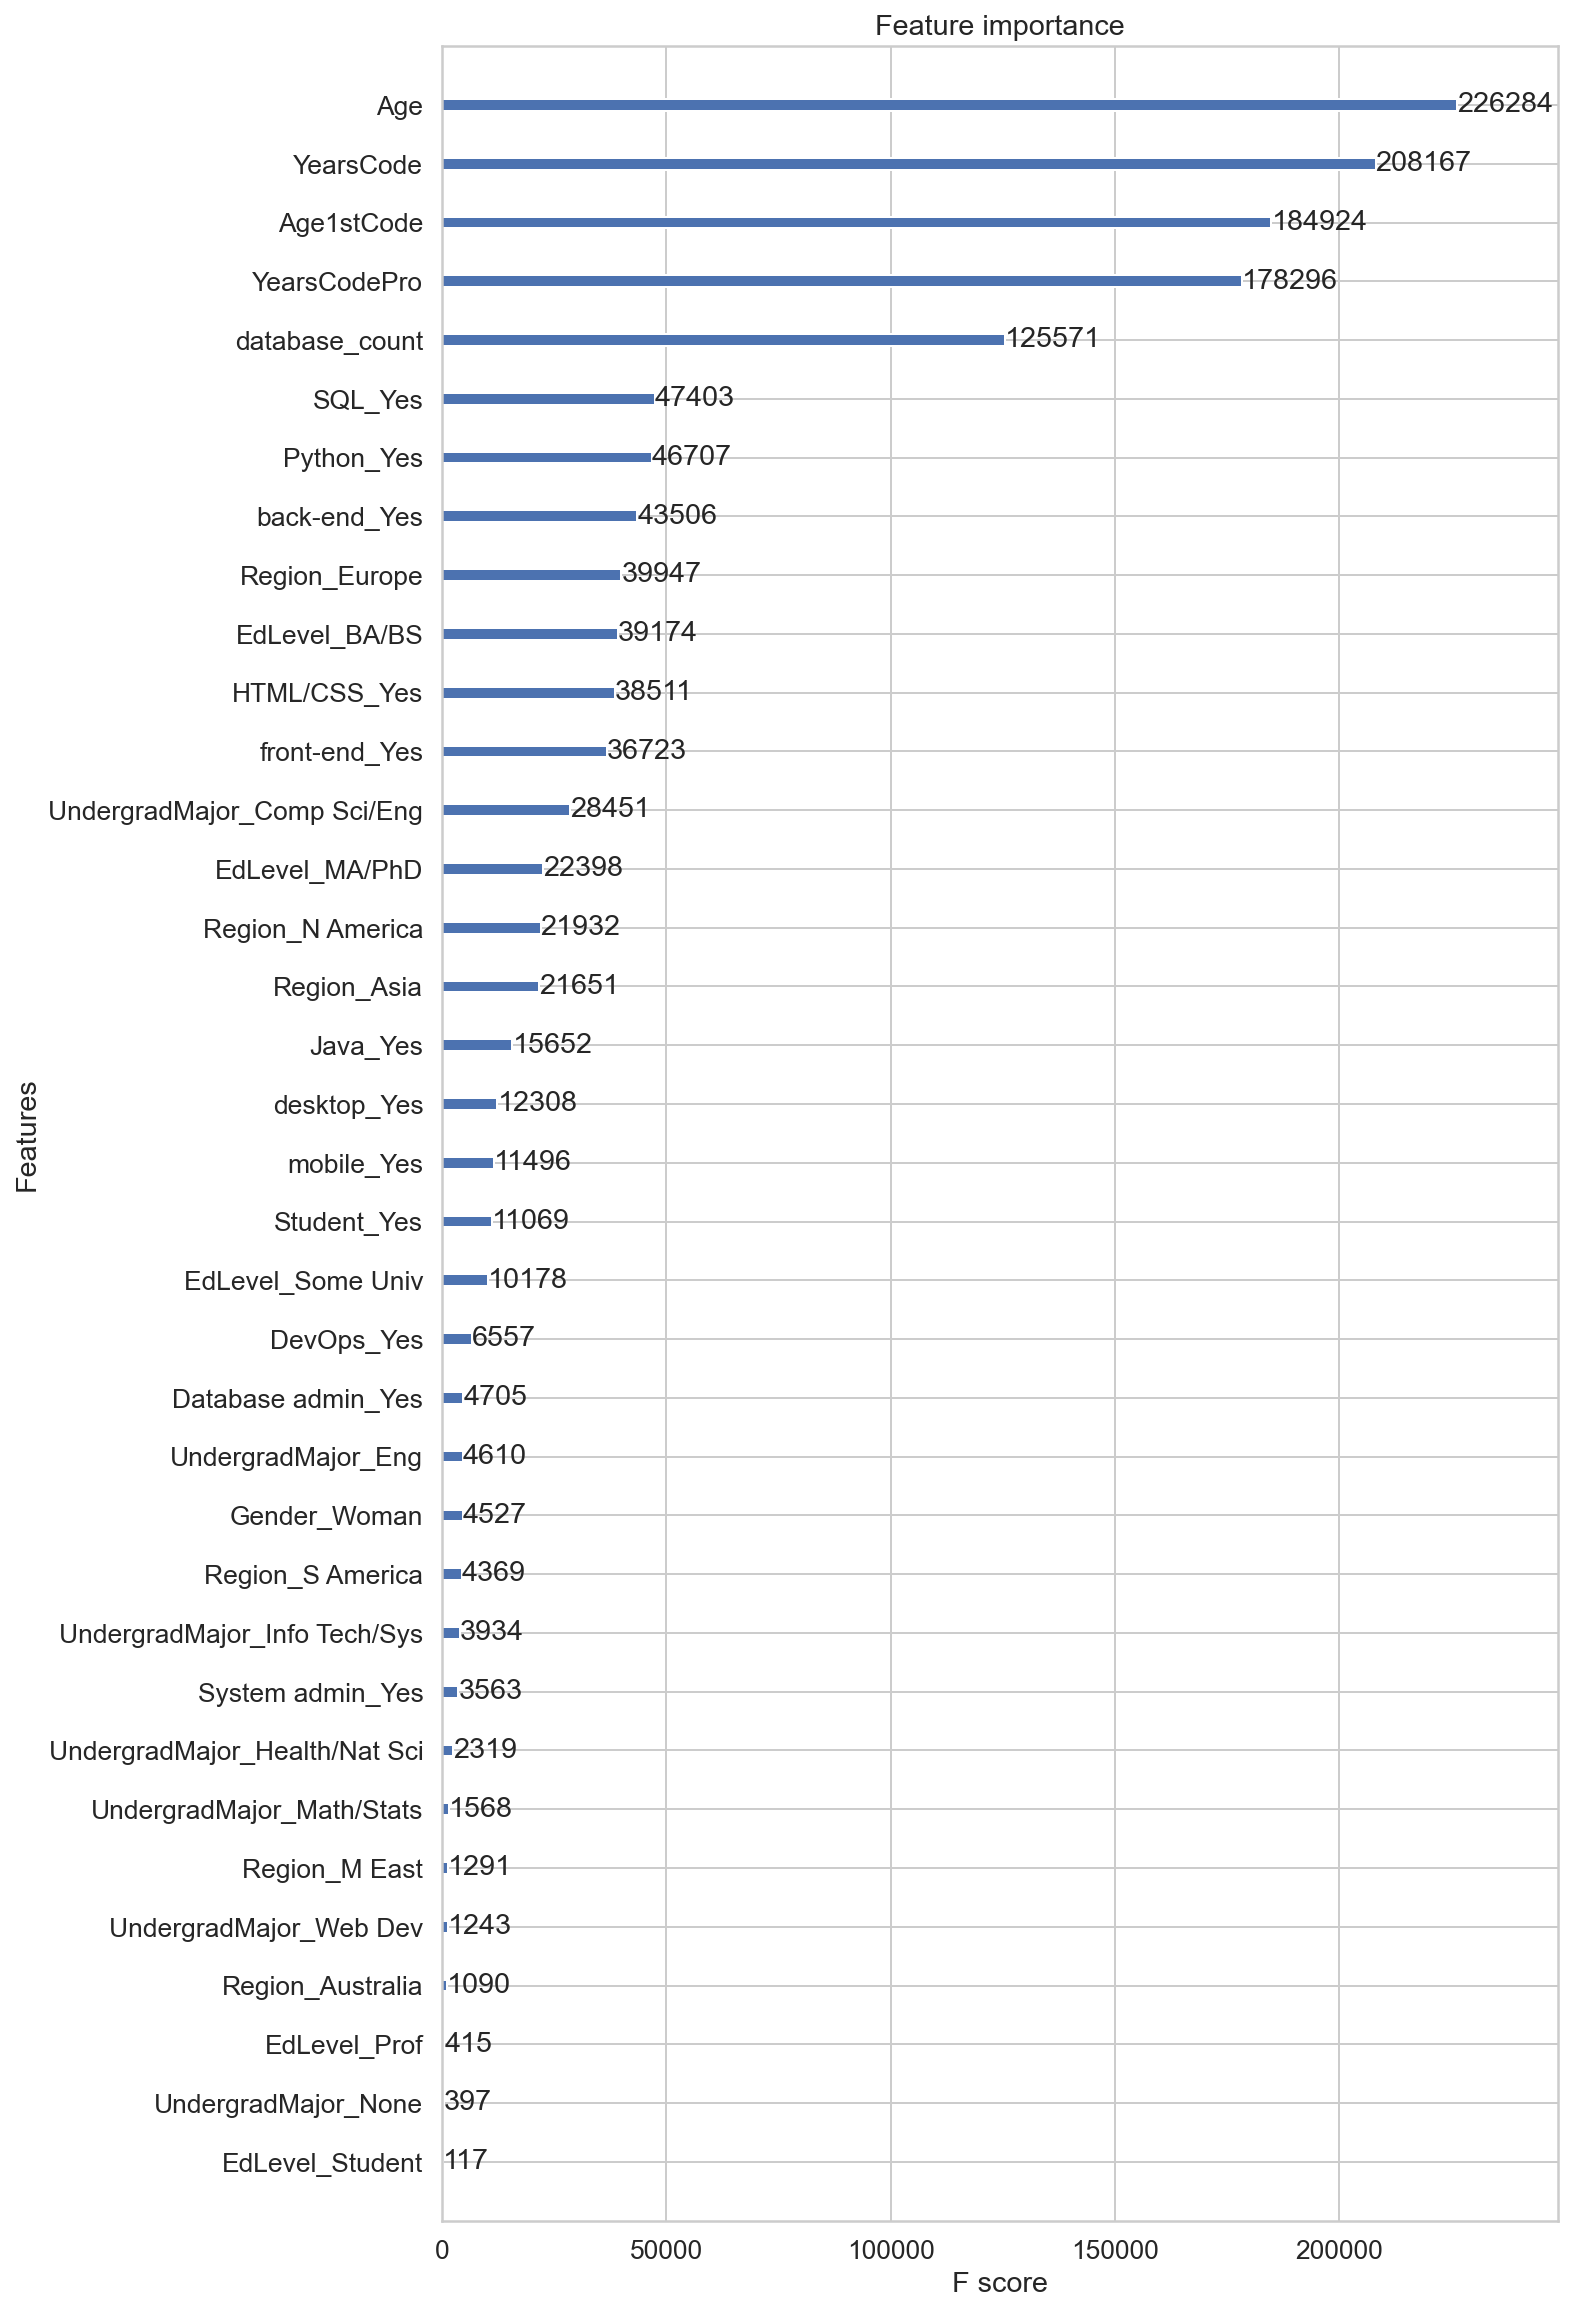

In [22]:
xgb.plot_importance(model)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.466933 to fit


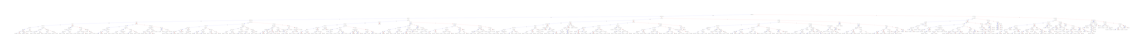

In [23]:
xgb.plot_tree(model, num_trees=0)
plt.rcParams['figure.figsize'] = [50, 15]
plt.show()